In [1]:
!pip install kaggle

In [2]:
import os
import numpy as np
import pandas as pd
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [3]:
# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 28.5MB/s]
100% 15.1M/15.1M [00:00<00:00, 68.1MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: data/brain_tumor_dataset/no/10 no.jpg  
  inflating: data/brain_tumor_dataset/no/11 no.jpg  
  inflating: data/brain_tumor_dataset/no/12 no.jpg  
  inflating: data/brain_tumor_dataset/no/13 no.jpg  
  inflating: data/brain_tumor_dataset/no/14 no.jpg  
  inflating: data/brain_tumor_dataset/no/15 no.jpg  
  inflating: data/brain_tumor_dataset/no/17 no.jpg  
  inflating: data/brain_tumor_dataset/no/18 no.jpg  
  inflating: data/brain_tumor_dataset/no/19 no.jpg  
  inflating: data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: data/brain_tumor_dataset/no/20 no.jpg  
  inflating: data/brain_tumor_dataset/no/21 no.jpg  
  inflating: data/brain_tumor_dataset/no/22 n

In [4]:
# Set data paths
data_dir = 'data/brain_tumor_dataset'
categories = ['yes', 'no']

In [5]:
# Initialize lists to hold the images and labels
tumor = []
healthy = []

# Load tumor images
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

# Load healthy images
for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [6]:
# Convert lists to numpy arrays
tumor = np.array(tumor)
healthy = np.array(healthy)
All = np.concatenate((healthy, tumor))

In [7]:
healthy.shape

(85, 128, 128, 3)

In [8]:
tumor.shape

(86, 128, 128, 3)

In [9]:
np.random.choice(10, 5, replace=False)

array([6, 1, 5, 8, 7])

#Visualizing the MRI Dataset

In [10]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

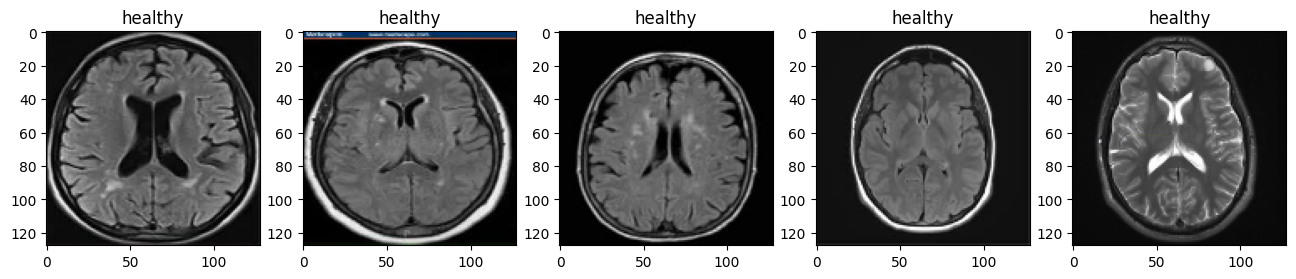

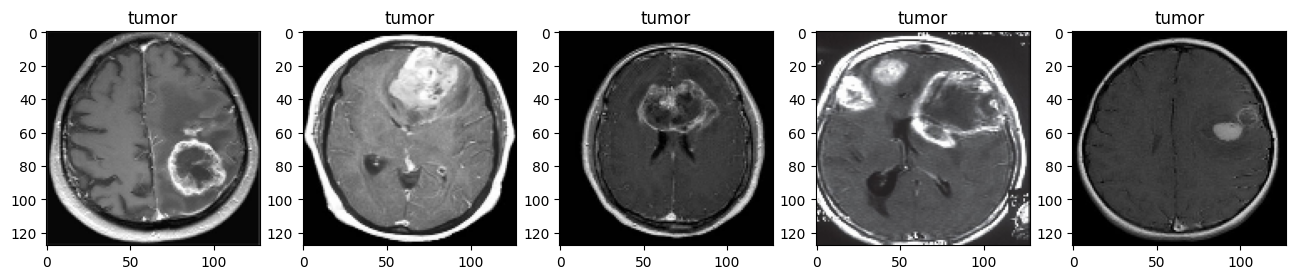

In [11]:
plot_random(healthy, tumor, num=5)

In [22]:
from sklearn.model_selection import train_test_split, KFold
from skimage.segmentation import slic
from skimage.filters import gaussian

In [23]:
# Create labels
tumor_labels = np.ones(len(tumor))
healthy_labels = np.zeros(len(healthy))

# Combine the data and labels
X = np.concatenate((tumor, healthy), axis=0)
y = np.concatenate((tumor_labels, healthy_labels), axis=0)

# Normalize the data
X = X / 255.0

In [24]:
# Apply superpixeling and smoothing techniques
def preprocess_image(image):
    segments = slic(image, n_segments=100, compactness=10, sigma=1)
    smooth_image = gaussian(image, sigma=1, multichannel=True)
    return smooth_image

X_preprocessed = np.array([preprocess_image(img) for img in X])

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_preprocessed):
    X_train, X_test = X_preprocessed[train_index], X_preprocessed[test_index]
    y_train, y_test = y[train_index], y[test_index]

<ipython-input-24-b1d1882416f9>:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  smooth_image = gaussian(image, sigma=1, multichannel=True)


In [25]:
# Count the number of images in the training and test sets
num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]

print(f'Number of training images: {num_train_images}')
print(f'Number of testing images: {num_test_images}')

Number of training images: 137
Number of testing images: 34


#Design a CNN Model

In [27]:
def create_cnn_model(input_shape, num_classes, dropout_rate=0.5):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (128, 128, 3)
num_classes = len(categories)
dropout_rate = 0.5  # Hyperparameter
model = create_cnn_model(input_shape, num_classes, dropout_rate)

In [29]:
from tensorflow.keras.optimizers import Adam

In [30]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the Model

In [31]:
# Hyperparameters
batch_size = 4
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
35/35 [==============================] - 4s 34ms/step - loss: 0.6469 - accuracy: 0.5985 - val_loss: 0.6361 - val_accuracy: 0.6471
Epoch 2/50
35/35 [==============================] - 0s 8ms/step - loss: 0.5899 - accuracy: 0.6934 - val_loss: 0.6398 - val_accuracy: 0.6471
Epoch 3/50
35/35 [==============================] - 0s 8ms/step - loss: 0.5487 - accuracy: 0.7299 - val_loss: 0.5195 - val_accuracy: 0.7647
Epoch 4/50
35/35 [==============================] - 0s 8ms/step - loss: 0.5198 - accuracy: 0.7445 - val_loss: 0.4636 - val_accuracy: 0.7353
Epoch 5/50
35/35 [==============================] - 0s 11ms/step - loss: 0.5129 - accuracy: 0.7299 - val_loss: 0.5670 - val_accuracy: 0.6471
Epoch 6/50
35/35 [==============================] - 0s 10ms/step - loss: 0.4832 - accuracy: 0.7810 - val_loss: 0.4656 - val_accuracy: 0.7647
Epoch 7/50
35/35 [==============================] - 0s 11ms/step - loss: 0.4677 - accuracy: 0.7664 - val_loss: 0.4420 - val_accuracy: 0.7647
Epoch 8/50
35/35

#Evaluate the Model

In [32]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 21ms/step - loss: 0.8096 - accuracy: 0.8529
Test Loss: 0.8095684051513672
Test Accuracy: 0.8529411554336548


#Visualize the Training History

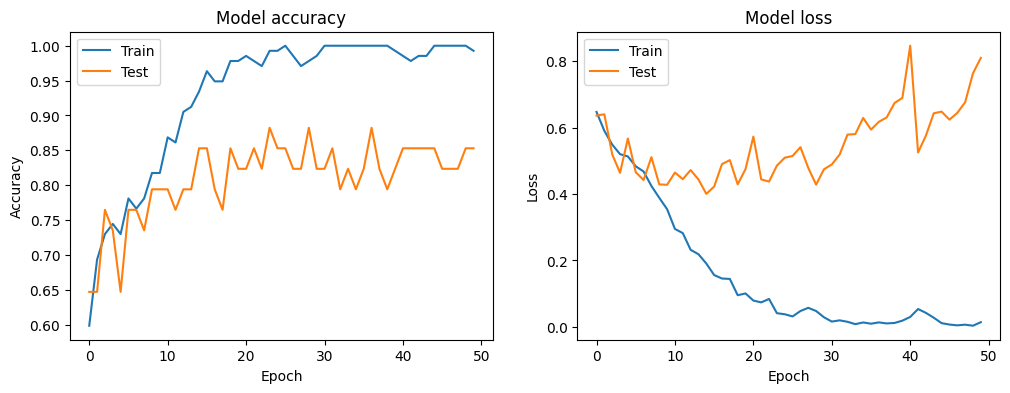

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [35]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 8ms/step


<Figure size 800x600 with 0 Axes>

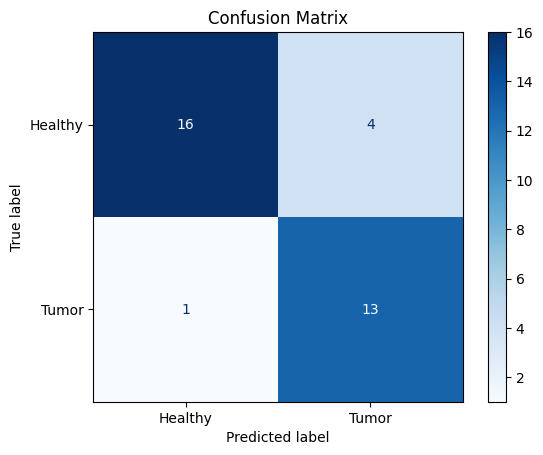

In [36]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Retrain the Model

In [37]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Hyperparameters
batch_size = 16
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 2s 112ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.7123 - val_accuracy: 0.8235
Epoch 2/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.8082 - val_accuracy: 0.8529
Epoch 3/50
9/9 [==============================] - 0s 19ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7962 - val_accuracy: 0.8235
Epoch 4/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.8235 - val_accuracy: 0.8529
Epoch 5/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.8413 - val_accuracy: 0.8529
Epoch 6/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7896 - val_accuracy: 0.8235
Epoch 7/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.7860 - val_accuracy: 0.8529
Epoch 8/50
9/9 [==========

#Evaluate the Model

In [39]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 13ms/step - loss: 0.9422 - accuracy: 0.8529
Test Loss: 0.9421901702880859
Test Accuracy: 0.8529411554336548


#Visualize the Training History

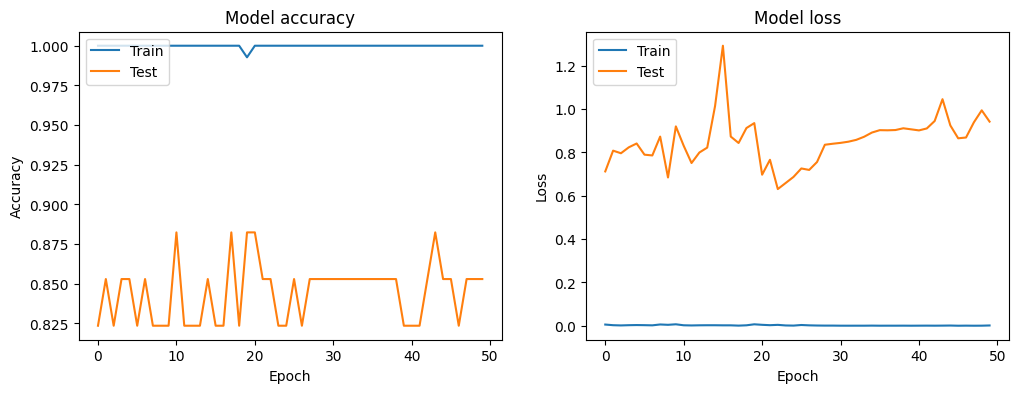

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [41]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 9ms/step


<Figure size 800x600 with 0 Axes>

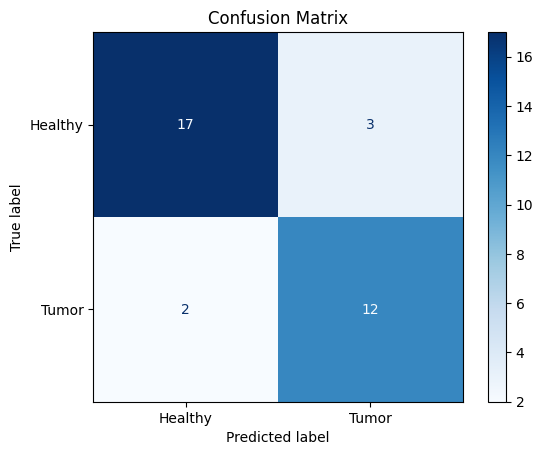

In [42]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()